# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [40]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
from scipy import fft
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 10000
SIGMA = 0.1*NBINS**0.5

In [53]:
# A toy model with a diffuse and point source component

def model(z, sigma = SIGMA):
    X = np.linspace(-3.1415, 3.1415, NBINS)
    mu = np.sin(X)*z[0] + np.cos(X)*z[1]
    n = np.random.randn(*mu.shape)*sigma
    return mu + n

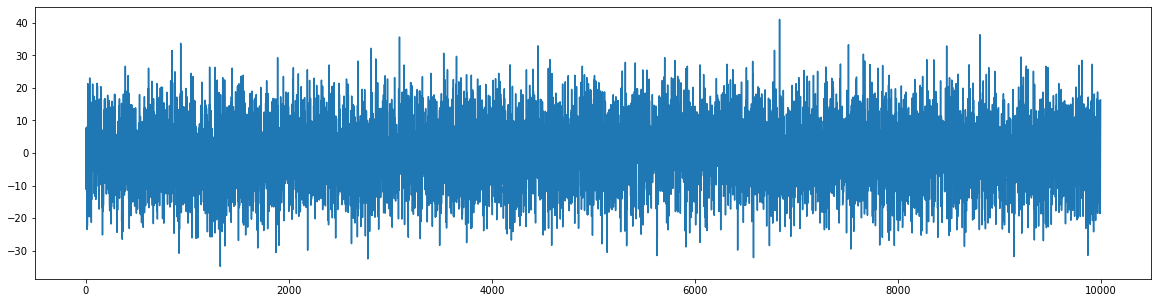

In [69]:
z0 = np.array([.5, 0.5])
x0 = model(z0)

plt.figure(figsize=(20,5))
plt.plot(x0)

In [34]:
err = SIGMA/np.sqrt(NBINS)  # 1/sqrt(2) = <sin^2>^(1/2) etc
print("Expected measurement error:", err)

Expected measurement error: 0.1


In [35]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.conv3 = torch.nn.Conv1d(20, 40, 5)
        self.pool = torch.nn.MaxPool1d(3)
        
    def forward(self, x):
        #return x.mean(-1).unsqueeze(-1)
        nbatch = len(x)
        
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [36]:
# Instantiate network

sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head)
sw.run(nrounds = 1, max_epochs = 3, recycle_net = False, nsamples = 10000)
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw.posterior(i, version = 0)
    plt.axvline(0.5)
    plt.scatter(z, p)
    plt.plot(z, stats.norm.pdf(z, 0.5, err))
plt.gca().set_yscale('log')

KeyboardInterrupt: 

In [23]:
# Convolutional network as HEAD of inference network

class Head2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(NBINS, 2)
        
    def forward(self, x):
        return self.lin1(x)

Number of output features: 2
Start training
Epoch: 0 []n 0
Epoch: 1 [4.101320177316666]
Epoch: 2 [4.101320177316666, 4.124218761920929]
Epoch: 0 []n 1
Epoch: 1 [3.9969523046165705]
Epoch: 2 [3.9969523046165705, 3.991884706541896]
Epoch: 0 []n 2
Epoch: 1 [3.9723906982690096]
Epoch: 2 [3.9723906982690096, 3.971573119983077]


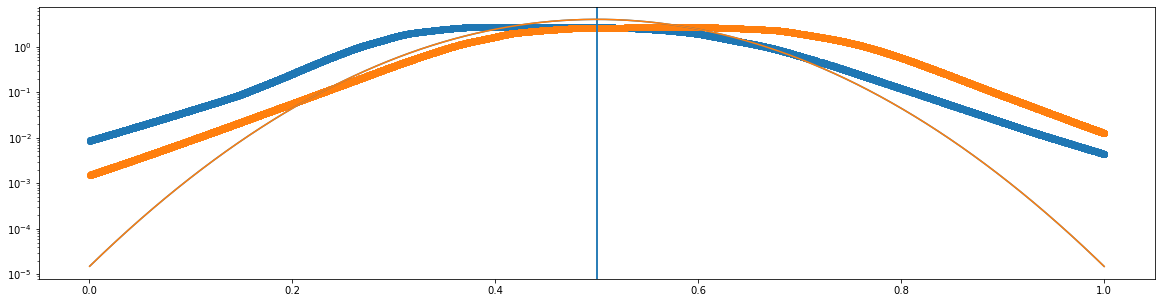

In [26]:
# Instantiate network

sw = swyft.SWYFT(x0, model, zdim = NDIM, device = DEVICE, head = Head2)
sw.run(nrounds = 1, max_epochs = 3, recycle_net = False, nsamples = 10000)
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw.posterior(i, version = 0)
    plt.axvline(0.5)
    plt.scatter(z, p)
    plt.plot(z, stats.norm.pdf(z, 0.5, err))
plt.gca().set_yscale('log')

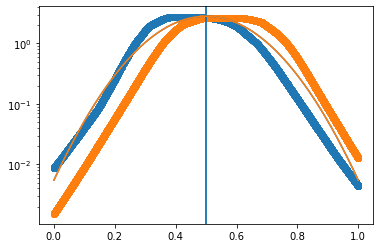

In [30]:
for i in range(2):
    z, p = sw.posterior(i, version = 0)
    plt.axvline(0.5)
    plt.scatter(z, p)
    plt.plot(z, stats.norm.pdf(z, 0.5, err*2**0.5))
plt.gca().set_yscale('log')

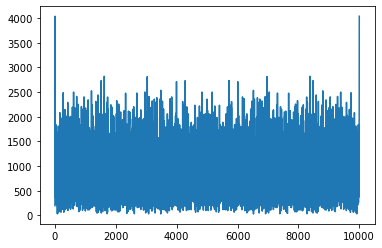

In [72]:
fft_x0 = fft.fft(x0)
plt.plot((np.real(fft_x0)**2 + np.imag(fft_x0)**2)**0.5)